#Data Preprocessing and Feature Engineering

### Data Cleaning Process

* Outlier Removal for ROCE

    - Applied both IQR **(1.5× rule)** and **Z-score (3σ)** methods to identify extreme values.
    - Removed identified outliers as ROCE is important to our classification and outliers would significantly affect the outcome.


* Winsorization of few Financial Metrics

    - Applied 5th-95th percentile winsorization to debt-to-equity and revenue growth
    - Capped extreme values rather than removing data points as we would not further reduce the dataset.


--- ROCE Outlier Detection and Removal ---
ROCE Summary Before Outlier Removal:
count     1279.000000
mean       -43.256103
std       1525.385608
min     -10648.664014
25%        -11.784393
50%          0.601162
75%          7.060634
max      50785.483867
Name: ROCE, dtype: float64
Number of outliers detected: 207 (16.18%)

ROCE Summary After Outlier Removal:
count    1072.000000
mean        1.560118
std        12.318358
min       -39.711870
25%        -4.511734
50%         2.046020
75%         8.126476
max        35.188076
Name: ROCE, dtype: float64


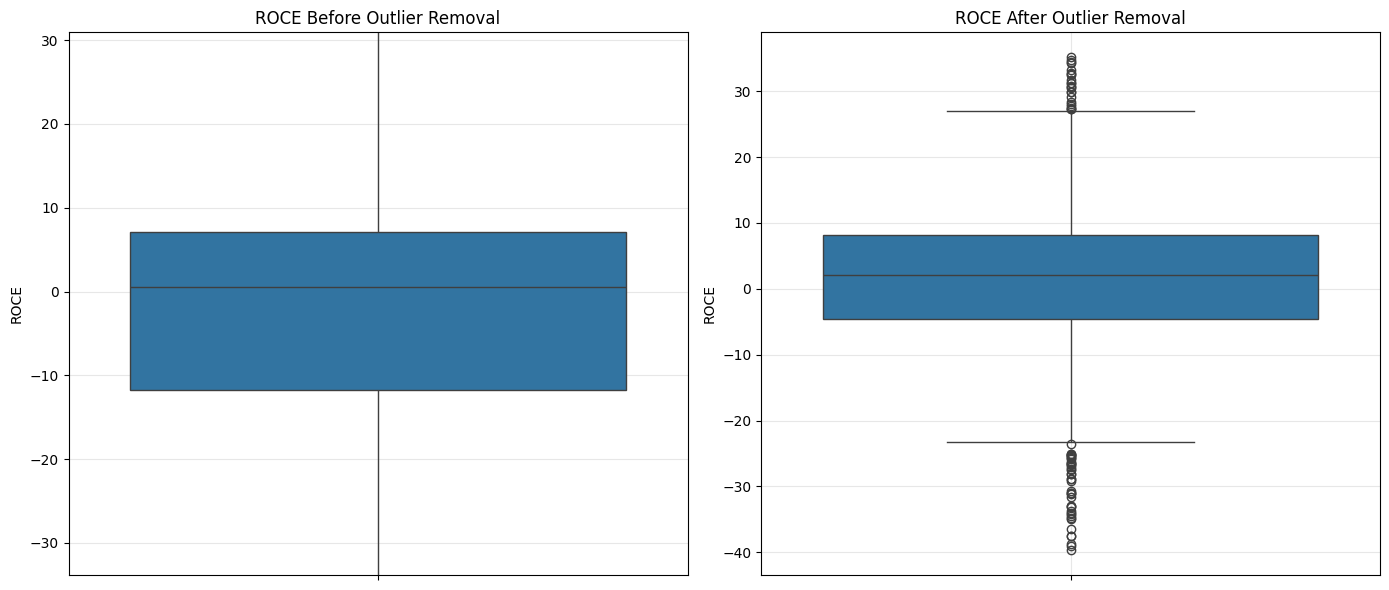

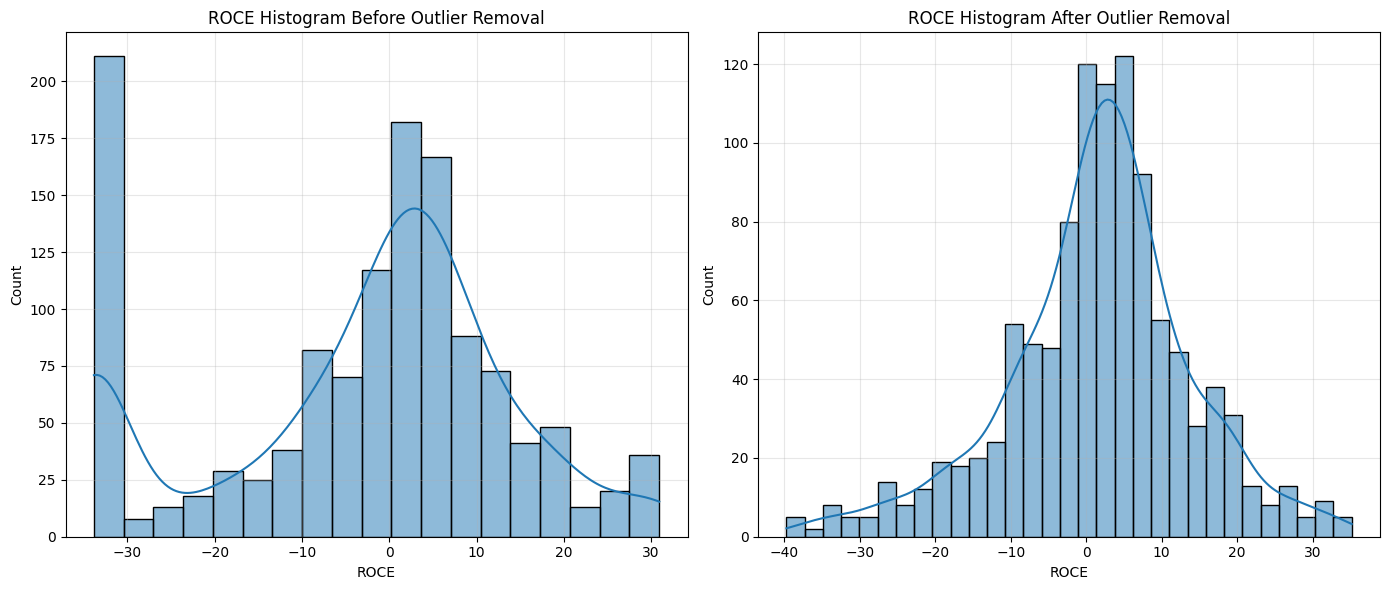


--- Winsorization of Selected Features ---

Winsorizing debtToEquity:
  Below 5th percentile (1.53): 5.04%
  Above 95th percentile (390.05): 5.04%
  Total points modified: 10.07%

Before winsorization:
count      1072.000000
mean        291.494853
std        5208.046319
min           0.002000
25%          20.320000
50%          46.790000
75%          83.347500
max      169413.140000
Name: debtToEquity, dtype: float64

After winsorization:
count    1072.000000
mean       78.681750
std        96.590707
min         1.532500
25%        20.320000
50%        46.790000
75%        83.347500
max       390.050450
Name: debtToEquity_winsorized, dtype: float64


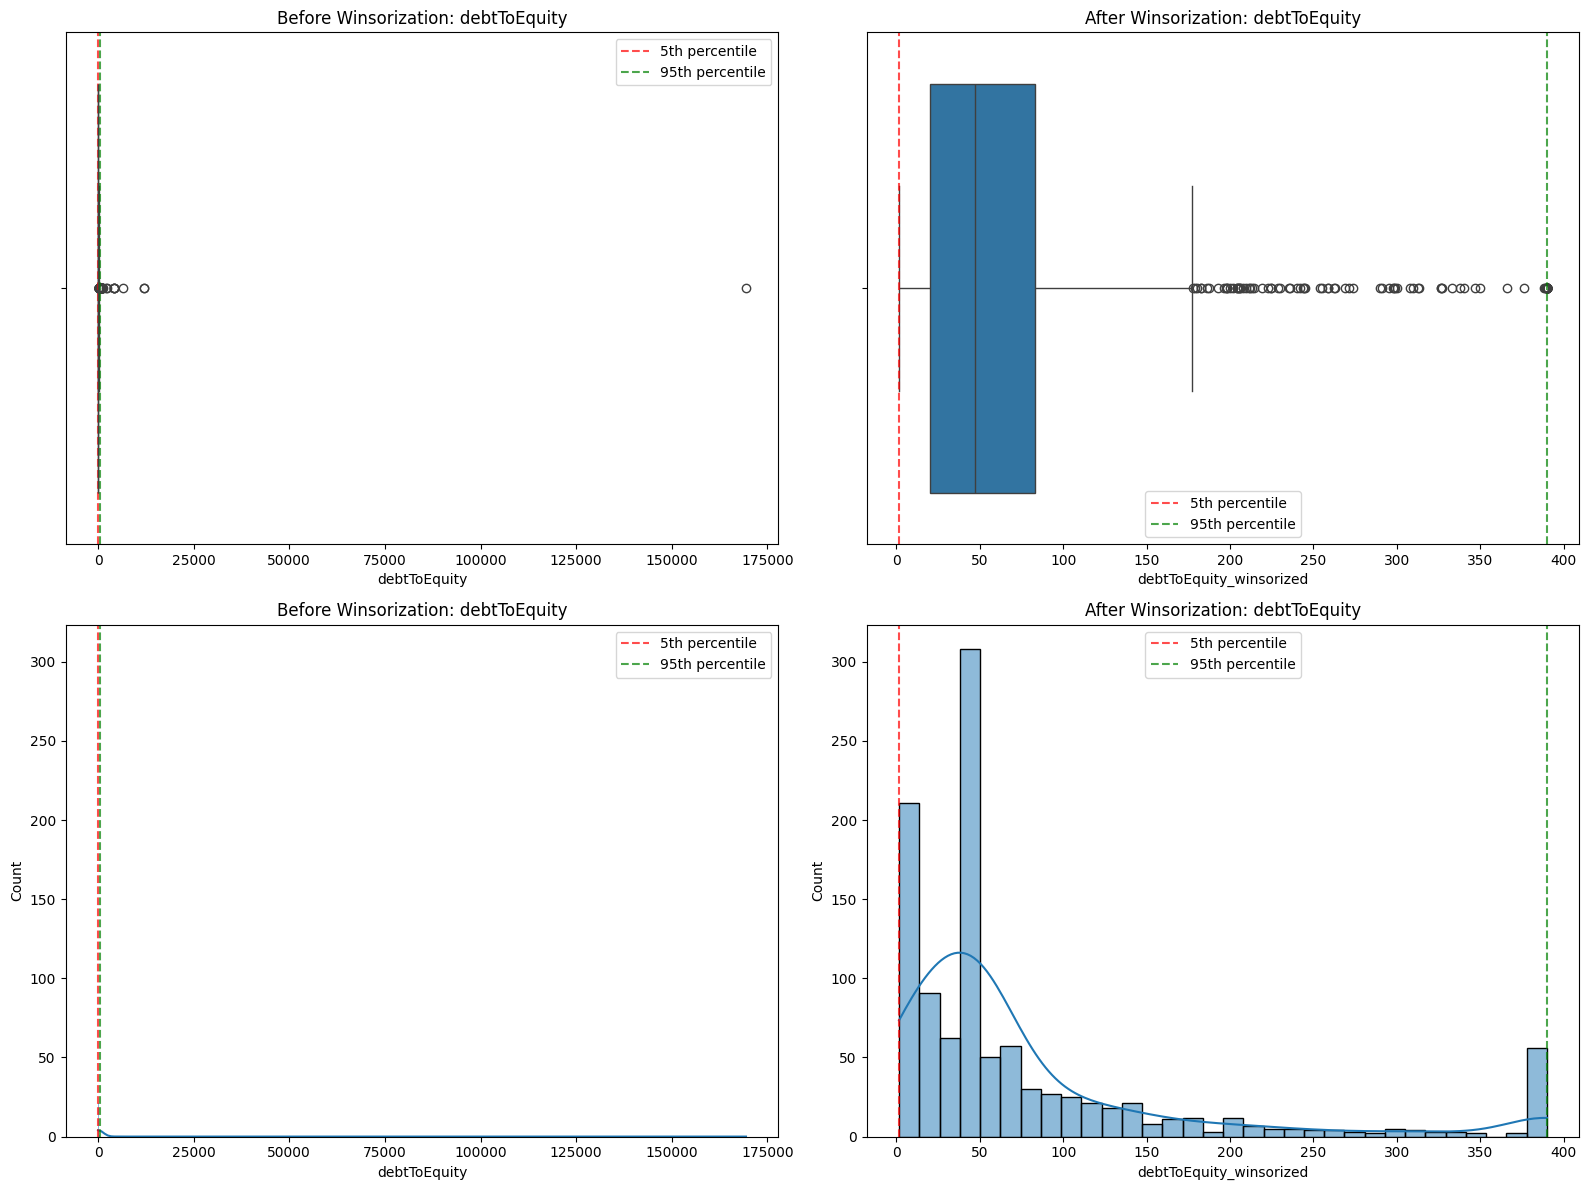


Winsorizing revenueGrowth:
  Below 5th percentile (-0.21): 5.04%
  Above 95th percentile (0.75): 5.04%
  Total points modified: 10.07%

Before winsorization:
count    1072.000000
mean        0.238299
std         1.639395
min        -1.000000
25%        -0.009000
50%         0.075000
75%         0.168000
max        43.554000
Name: revenueGrowth, dtype: float64

After winsorization:
count    1072.000000
mean        0.112557
std         0.218818
min        -0.210700
25%        -0.009000
50%         0.075000
75%         0.168000
max         0.753500
Name: revenueGrowth_winsorized, dtype: float64


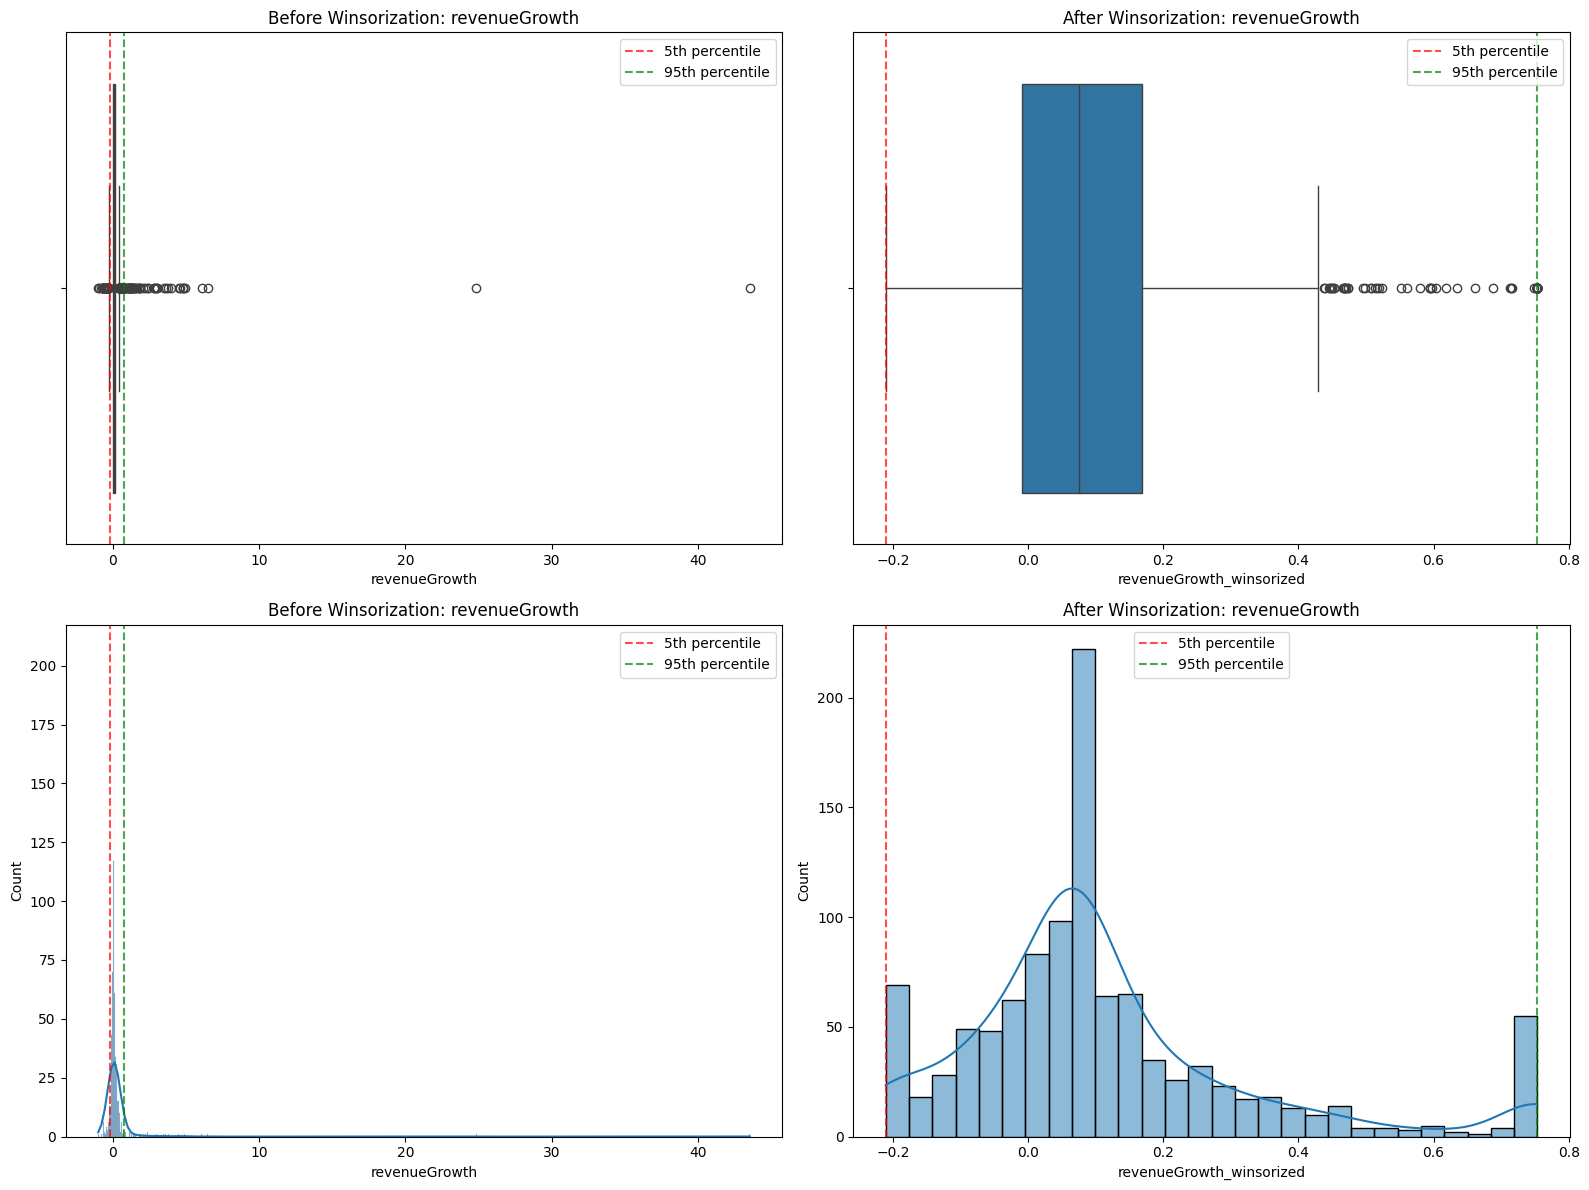


Final data saved with 1072 rows
Total rows removed due to outliers: 207


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
merged_data = pd.read_csv('merged_cleaned_stock_data_old.csv')

# ------------- PART 1: ROCE OUTLIER REMOVAL -------------
print("--- ROCE Outlier Detection and Removal ---")

# Detecting outliers using IQR method
def detect_outliers_iqr(df, column, whisker_multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - whisker_multiplier * IQR
    upper_bound = Q3 + whisker_multiplier * IQR
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    z_outliers = pd.Series(False, index=df.index)
    z_outliers[df[column].dropna().index] = z_scores > threshold
    return z_outliers

# Print summary statistics for ROCE before outlier removal
print("ROCE Summary Before Outlier Removal:")
print(merged_data['ROCE'].describe())

# Detect outliers in ROCE column using both methods
iqr_outliers = detect_outliers_iqr(merged_data, 'ROCE')
zscore_outliers = detect_outliers_zscore(merged_data, 'ROCE')
outliers = iqr_outliers | zscore_outliers

# Count and percentage of outliers
num_outliers = outliers.sum()
pct_outliers = (num_outliers / len(merged_data)) * 100
print(f"Number of outliers detected: {num_outliers} ({pct_outliers:.2f}%)")

# Remove outliers
data_clean = merged_data[~outliers].copy()

# Print summary statistics after outlier removal
print("\nROCE Summary After Outlier Removal:")
print(data_clean['ROCE'].describe())

# Create before and after box plots for ROCE
plt.figure(figsize=(14, 6))

# Calculate reasonable y-limits based on percentiles
y_min = data_clean['ROCE'].quantile(0.01)
y_max = data_clean['ROCE'].quantile(0.99)

# Before plot (zoomed)
plt.subplot(1, 2, 1)
sns.boxplot(y=merged_data['ROCE'])
plt.title('ROCE Before Outlier Removal')
plt.ylabel('ROCE')
plt.ylim(y_min, y_max)
plt.grid(True, alpha=0.3)

# After plot (zoomed)
plt.subplot(1, 2, 2)
sns.boxplot(y=data_clean['ROCE'])
plt.title('ROCE After Outlier Removal')
plt.ylabel('ROCE')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roce_outlier_removal.png', dpi=300)
plt.show()

# ROCE histograms
plt.figure(figsize=(14, 6))

# Before histogram
plt.subplot(1, 2, 1)
sns.histplot(merged_data['ROCE'].clip(y_min, y_max), kde=True)
plt.title('ROCE Histogram Before Outlier Removal')
plt.xlabel('ROCE')
plt.grid(True, alpha=0.3)

# After histogram
plt.subplot(1, 2, 2)
sns.histplot(data_clean['ROCE'], kde=True)
plt.title('ROCE Histogram After Outlier Removal')
plt.xlabel('ROCE')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roce_histograms.png', dpi=300)
plt.show()

# ------------- PART 2: WINSORIZATION OF KEY FEATURES -------------
print("\n--- Winsorization of Selected Features ---")

# Features to winsorize (from the first file)
columns_to_winsorize = ['debtToEquity', 'revenueGrowth']

# Create a copy for winsorization (starting with the data after ROCE outlier removal)
df_winsorized = data_clean.copy()

# Process each column for winsorization
for col in columns_to_winsorize:
    print(f"\nWinsorizing {col}:")

    # Calculate the 5th and 95th percentiles for winsorization
    q_low = df_winsorized[col].quantile(0.05)
    q_high = df_winsorized[col].quantile(0.95)

    # Calculate what percentage of the data will be affected
    pct_below = (df_winsorized[col] < q_low).mean() * 100
    pct_above = (df_winsorized[col] > q_high).mean() * 100

    print(f"  Below 5th percentile ({q_low:.2f}): {pct_below:.2f}%")
    print(f"  Above 95th percentile ({q_high:.2f}): {pct_above:.2f}%")
    print(f"  Total points modified: {pct_below + pct_above:.2f}%")

    # Apply winsorization - create new column
    df_winsorized[col + '_winsorized'] = df_winsorized[col].clip(lower=q_low, upper=q_high)

    # Print statistics before and after
    print("\nBefore winsorization:")
    print(df_winsorized[col].describe())
    print("\nAfter winsorization:")
    print(df_winsorized[col + '_winsorized'].describe())

    # Create visualization
    plt.figure(figsize=(16, 12))

    # Boxplots
    plt.subplot(2, 2, 1)
    sns.boxplot(x=df_winsorized[col])
    plt.title(f'Before Winsorization: {col}')
    plt.axvline(q_low, color='r', linestyle='--', alpha=0.7, label='5th percentile')
    plt.axvline(q_high, color='g', linestyle='--', alpha=0.7, label='95th percentile')
    plt.legend()

    plt.subplot(2, 2, 2)
    sns.boxplot(x=df_winsorized[col + '_winsorized'])
    plt.title(f'After Winsorization: {col}')
    plt.axvline(q_low, color='r', linestyle='--', alpha=0.7, label='5th percentile')
    plt.axvline(q_high, color='g', linestyle='--', alpha=0.7, label='95th percentile')
    plt.legend()

    # Histograms
    plt.subplot(2, 2, 3)
    sns.histplot(df_winsorized[col], kde=True)
    plt.title(f'Before Winsorization: {col}')
    plt.axvline(q_low, color='r', linestyle='--', alpha=0.7, label='5th percentile')
    plt.axvline(q_high, color='g', linestyle='--', alpha=0.7, label='95th percentile')
    plt.legend()

    plt.subplot(2, 2, 4)
    sns.histplot(df_winsorized[col + '_winsorized'], kde=True)
    plt.title(f'After Winsorization: {col}')
    plt.axvline(q_low, color='r', linestyle='--', alpha=0.7, label='5th percentile')
    plt.axvline(q_high, color='g', linestyle='--', alpha=0.7, label='95th percentile')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{col}_winsorization.png', dpi=300)
    plt.show()

# Apply the winsorized values back to the main columns if needed
for col in columns_to_winsorize:
    df_winsorized[col] = df_winsorized[col + '_winsorized']
    df_winsorized.drop(columns=[col + '_winsorized'], inplace=True)

# Save the cleaned and winsorized data
df_winsorized.to_csv('merged_cleaned_stock_data.csv', index=False)
print(f"\nFinal data saved with {len(df_winsorized)} rows")
print(f"Total rows removed due to outliers: {len(merged_data) - len(df_winsorized)}")

## Imputing Missing Values

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# Load datasets
df = pd.read_csv('/content/merged_cleaned_stock_data.csv')
ten_year_data = pd.read_csv('/content/deduplicated_combined_data.csv')

# Merge datasets on stock symbol
df['symbol_upper'] = df['symbol'].str.upper()  # Ensure consistent casing
ten_year_data['Stock_upper'] = ten_year_data['Stock'].str.upper()
merged_df = pd.merge(df, ten_year_data, how='left', left_on='symbol_upper', right_on='Stock_upper')

# Select features for Coffee Can strategy
features = ['ROCE', 'grossMargins', 'revenueGrowth',
            'earningsQuarterlyGrowth', 'debtToEquity', 'freeCashflow', 'marketCap']

# Create a copy with relevant columns
X = merged_df[['symbol', 'IPO_Year', 'Years_Since_IPO'] + features].copy()

# Handle missing years since IPO - default to 4 years if missing (assuming young stock)
current_year = 2025  # Adjust as needed
X['IPO_Year'] = X['IPO_Year'].fillna(current_year - 10)
X['Years_Since_IPO'] = X['Years_Since_IPO'].fillna(4)

# Handle extreme outliers (winsorize) for debtToEquity and revenueGrowth
for col in ['debtToEquity', 'revenueGrowth']:
    q_low = X[col].quantile(0.05)
    q_high = X[col].quantile(0.95)
    X[col] = np.where(X[col] < q_low, q_low, X[col])
    X[col] = np.where(X[col] > q_high, q_high, X[col])

# Any other missing values in features are filled by median
X[features] = X[features].fillna(X[features].median())

# Preparing data for Classification

Total stocks: 1115
Mature stocks (>5 years): 814
Young stocks (≤5 years): 301

Based on Coffee Can criteria, 195 out of 814 mature stocks are eligible (24.0%)
Balanced accuracy on test set: 0.99
ROC AUC score: 1.00

Model Evaluation (Mature Stocks):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       155
           1       0.98      0.98      0.98        49

    accuracy                           0.99       204
   macro avg       0.99      0.99      0.99       204
weighted avg       0.99      0.99      0.99       204

Confusion Matrix:
[[154   1]
 [  1  48]]

Feature Importance:
                         Importance
ROCE                       0.370351
revenueGrowth              0.230287
debtToEquity               0.168118
grossMargins               0.145038
marketCap                  0.032661
earningsQuarterlyGrowth    0.032330
freeCashflow               0.021214


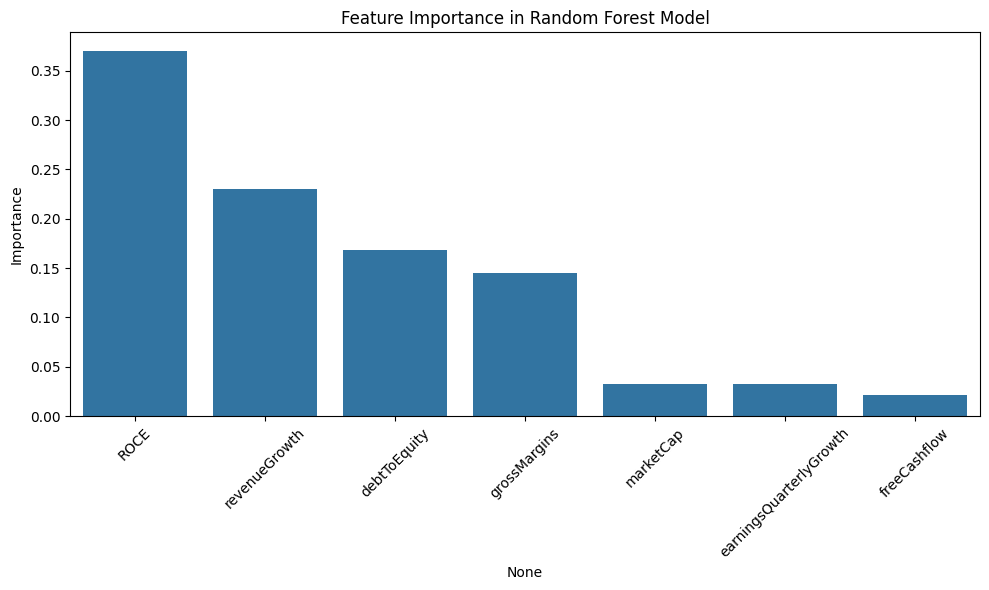

In [ ]:


# Split into mature and young stocks
mature_stocks = X[X['Years_Since_IPO'] > 5].copy()
young_stocks = X[X['Years_Since_IPO'] <= 5].copy()

print(f"Total stocks: {len(X)}")
print(f"Mature stocks (>5 years): {len(mature_stocks)}")
print(f"Young stocks (≤5 years): {len(young_stocks)}")

# Create binary labels based on Coffee Can criteria for mature stocks
# Use these as training data for the model

# Coffee Can Scoring Criteria
ROCE_threshold = mature_stocks['ROCE'].quantile(0.70)  # Top 30% of stocks by ROCE
margin_threshold = mature_stocks['grossMargins'].quantile(0.60)  # Top 40% of stocks by margins
growth_threshold = mature_stocks['revenueGrowth'].quantile(0.50)  # Above median growth
debt_threshold = mature_stocks['debtToEquity'].quantile(0.40)  # Bottom 40% of stocks by debt (lower is better)

# filtering based on the criteria
mature_stocks['high_ROCE'] = mature_stocks['ROCE'] >= ROCE_threshold
mature_stocks['high_margins'] = mature_stocks['grossMargins'] >= margin_threshold
mature_stocks['good_growth'] = mature_stocks['revenueGrowth'] >= growth_threshold
mature_stocks['low_debt'] = mature_stocks['debtToEquity'] <= debt_threshold

# Scoring by summing the criteria (0-4 scale)
mature_stocks['coffee_score'] = mature_stocks['high_ROCE'].astype(int) + \
                             mature_stocks['high_margins'].astype(int) + \
                             mature_stocks['good_growth'].astype(int) + \
                             mature_stocks['low_debt'].astype(int)

# Convert to binary labels based on meeting at least 3 of 4 criteria
# 1 = Eligible for Coffee Can portfolio
# 0 = Not eligible
mature_stocks['eligible'] = (mature_stocks['coffee_score'] >= 3).astype(int)

# Printing how many mature stocks are eligible
eligible_count = mature_stocks['eligible'].sum()
print(f"\nBased on Coffee Can criteria, {eligible_count} out of {len(mature_stocks)} mature stocks are eligible ({eligible_count/len(mature_stocks)*100:.1f}%)")


# Defining dependent and indepenedent
X_mature_features = mature_stocks[features].values
y_mature = mature_stocks['eligible'].values

# Scaling the features
scaler = StandardScaler()
X_mature_scaled = scaler.fit_transform(X_mature_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_mature_scaled, y_mature, test_size=0.25, random_state=42, stratify=y_mature
)

#SMOTE pipeline for handling class imbalance
smote_pipeline = imbPipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.7)),  # Increasing the eligible (1) class, but not to full 50/50
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Train the model
smote_pipeline.fit(X_train, y_train)
rf_model = smote_pipeline.named_steps['classifier']



# Evaluate the model on test set
y_pred = smote_pipeline.predict(X_test)
y_pred_proba = smote_pipeline.predict_proba(X_test)[:, 1]

# computing balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy on test set: {balanced_acc:.2f}")

# Compute AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {auc_score:.2f}")

# Print classification report
print("\nModel Evaluation (Mature Stocks):")
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# feature importance
feature_importance = pd.DataFrame(
    data=rf_model.feature_importances_,
    index=features,
    columns=['Importance']
).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.index, y=feature_importance['Importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Predicting Young Stocks < 5 years old


Predicted Eligible Young Stocks (≤5 years):
DUOL - ROCE: 11.00, Margin: 0.73, Growth: 0.39, DebtToEquity: 6.94, Years Since IPO: 3.7, Probability: 0.99, Coffee Score: 4
ABNB - ROCE: 19.77, Margin: 0.83, Growth: 0.12, DebtToEquity: 27.27, Years Since IPO: 4.2, Probability: 0.99, Coffee Score: 4
BDMD - ROCE: 25.83, Margin: 0.88, Growth: 0.14, DebtToEquity: 39.53, Years Since IPO: 3.2, Probability: 0.99, Coffee Score: 4
ARM - ROCE: 20.33, Margin: 0.96, Growth: 0.19, DebtToEquity: 4.22, Years Since IPO: 1.5, Probability: 0.99, Coffee Score: 4
GAMB - ROCE: 18.88, Margin: 0.92, Growth: 0.37, DebtToEquity: 23.82, Years Since IPO: 3.7, Probability: 0.98, Coffee Score: 4
ICG - ROCE: 18.26, Margin: 0.54, Growth: 0.73, DebtToEquity: 1.62, Years Since IPO: 2.0, Probability: 0.98, Coffee Score: 4
HPAI - ROCE: 21.38, Margin: 0.63, Growth: 0.73, DebtToEquity: 37.45, Years Since IPO: 0.6, Probability: 0.97, Coffee Score: 4
HRMY - ROCE: 16.24, Margin: 0.78, Growth: 0.20, DebtToEquity: 27.52, Years Sin

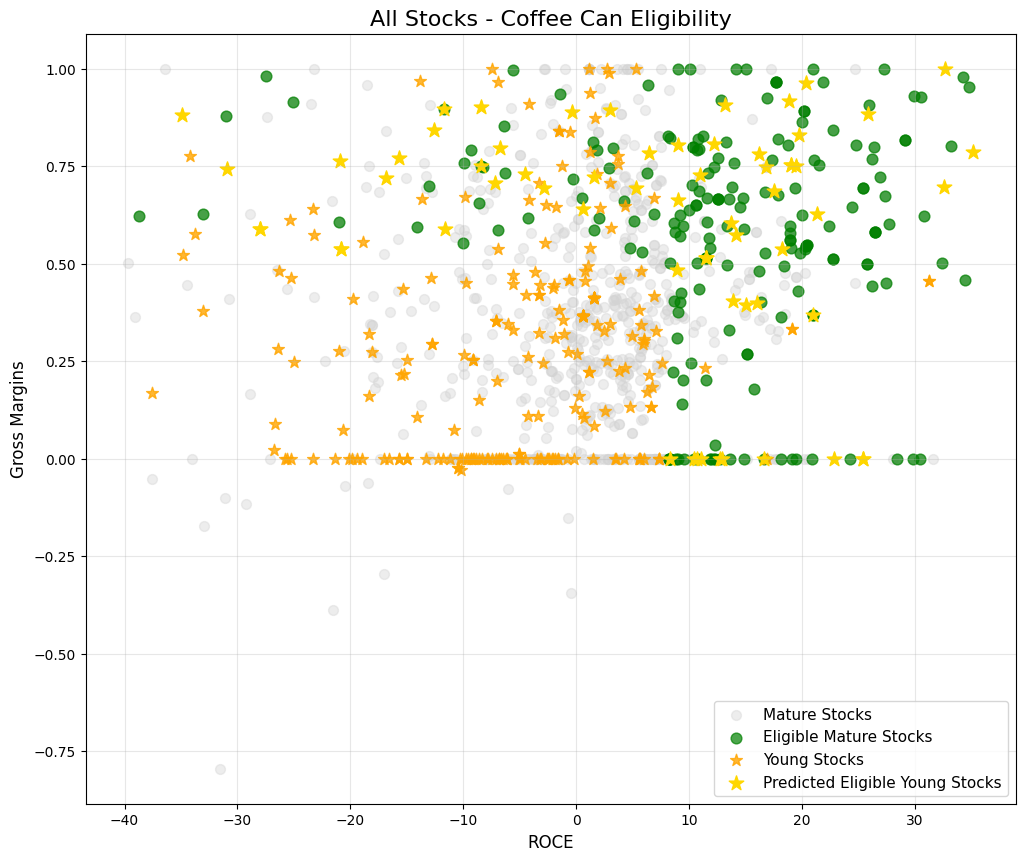

In [ ]:
# Apply the model to young stocks
X_young_features = young_stocks[features].values
X_young_scaled = scaler.transform(X_young_features)  # Use the same scaler as for mature stocks

young_stocks['predicted_eligibility'] = smote_pipeline.predict(X_young_scaled)
young_stocks['probability_eligible'] = smote_pipeline.predict_proba(X_young_scaled)[:, 1]

# Apply the same criteria-based scoring to young stocks (for comparison)
young_stocks['high_ROCE'] = young_stocks['ROCE'] >= ROCE_threshold
young_stocks['high_margins'] = young_stocks['grossMargins'] >= margin_threshold
young_stocks['good_growth'] = young_stocks['revenueGrowth'] >= growth_threshold
young_stocks['low_debt'] = young_stocks['debtToEquity'] <= debt_threshold

young_stocks['coffee_score'] = young_stocks['high_ROCE'].astype(int) + \
                            young_stocks['high_margins'].astype(int) + \
                            young_stocks['good_growth'].astype(int) + \
                            young_stocks['low_debt'].astype(int)

# Print young stock predictions
print("\nPredicted Eligible Young Stocks (≤5 years):")

young_eligible = young_stocks[young_stocks['predicted_eligibility'] == 1].sort_values('probability_eligible', ascending=False)

if len(young_eligible) > 0:
    for idx, row in young_eligible.head(15).iterrows():  # Limit to top 15 by probability
        print(f"{row['symbol']} - ROCE: {row['ROCE']:.2f}, Margin: {row['grossMargins']:.2f}, "
              f"Growth: {row['revenueGrowth']:.2f}, DebtToEquity: {row['debtToEquity']:.2f}, "
              f"Years Since IPO: {row['Years_Since_IPO']:.1f}, Probability: {row['probability_eligible']:.2f}, "
              f"Coffee Score: {row['coffee_score']}")
else:
    print("No young stocks predicted to be eligible")

# Compare model predictions with criteria-based scoring for young stocks
compare_df = young_stocks[['symbol', 'ROCE', 'grossMargins', 'revenueGrowth', 'debtToEquity',
                        'Years_Since_IPO', 'coffee_score', 'predicted_eligibility', 'probability_eligible']]

print("\nYoung Stocks Comparison (Raw Coffee Score vs Model Prediction):")
for idx, row in compare_df.sort_values('probability_eligible', ascending=False).head(15).iterrows():
    print(f"{row['symbol']} - Score: {row['coffee_score']}/4, Prediction: {row['predicted_eligibility']}, "
          f"Probability: {row['probability_eligible']:.2f}")

# saving results to CSV for easier computation
mature_stocks.to_csv('mature_stocks_eligibility.csv', index=False)
young_stocks.to_csv('young_stocks_eligibility.csv', index=False)
eligible_stocks = pd.concat([mature_stocks, young_stocks])
eligible_stocks.to_csv('eligible_stocks.csv', index=False)
# collecting sll the elibile stocks
all_eligible = pd.concat([
    mature_stocks[mature_stocks['eligible'] == 1][['symbol', 'ROCE', 'grossMargins', 'revenueGrowth',
                                                'debtToEquity', 'Years_Since_IPO']],
    young_stocks[young_stocks['predicted_eligibility'] == 1][['symbol', 'ROCE', 'grossMargins', 'revenueGrowth',
                                                           'debtToEquity', 'Years_Since_IPO']]
])

all_eligible['stock_age'] = np.where(all_eligible['Years_Since_IPO'] > 5, 'Mature', 'Young')
all_eligible.sort_values(['stock_age', 'ROCE'], ascending=[False, False]).to_csv('all_eligible_stocks.csv', index=False)

print(f"\nTotal eligible stocks: {len(all_eligible)}")
print(f"Results exported to CSV files.")


plt.figure(figsize=(12, 10))

# mature stocks
plt.scatter(mature_stocks['ROCE'], mature_stocks['grossMargins'],
           c='lightgray', alpha=0.4, s=50, marker='o', label='Mature Stocks')

# eligible mature stocks
mature_eligible = mature_stocks[mature_stocks['eligible'] == 1]
plt.scatter(mature_eligible['ROCE'], mature_eligible['grossMargins'],
           c='green', alpha=0.7, s=60, marker='o', label='Eligible Mature Stocks')

# young stocks with star markers in orange
plt.scatter(young_stocks['ROCE'], young_stocks['grossMargins'],
           c='orange', alpha=0.8, s=80, marker='*', label='Young Stocks')

# predicted eligible young stocks
young_eligible = young_stocks[young_stocks['predicted_eligibility'] == 1]
plt.scatter(young_eligible['ROCE'], young_eligible['grossMargins'],
           c='gold', alpha=1.0, s=120, marker='*', label='Predicted Eligible Young Stocks')

plt.xlabel('ROCE', fontsize=12)
plt.ylabel('Gross Margins', fontsize=12)
plt.title('All Stocks - Coffee Can Eligibility', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

plt.show()

# Mean Variance Optimization

### Covariance Matrix Generation

   - Created a correlation matrix using Beta similarity as a proxy as stocks with similar Beta values (market senssitivity) move together similarly and therefore were assigned higher correlations
   - Constructed a covariance matrix using individual stock volatilities and correlation estimates.



### Return Estimation Approach
  - Used risk-free rate (4%) plus Sharpe ratio × Volatility to estimate expected returns

### Implemented Mean-Variance Optimization (MVO) with the Sharpe ratio as objective function
   - Applied Sequential Least Squares Programming (SLSQP) algorithm to minimize the negative Sharpe ratio, which is mathematically equivalent to maximizing it
   - Applied practical constraints to ensure diversification:

        * Large cap allocation > Small and Mid cap
        * Mature stock allocation > Young stock allocation
        * 100% allocation

Loading datasets...

Merging datasets...
Index(['symbol', 'IPO_Year', 'Years_Since_IPO', 'ROCE', 'grossMargins',
       'revenueGrowth', 'earningsQuarterlyGrowth', 'debtToEquity',
       'freeCashflow', 'marketCap', 'high_ROCE', 'high_margins', 'good_growth',
       'low_debt', 'coffee_score', 'eligible', 'age_category', 'source',
       'symbol_upper', 'Stock', 'Beta', 'Volatility', 'Sharpe_Ratio',
       'Max_Drawdown', 'VaR_95', 'Downside_Deviation', 'Sortino_Ratio',
       'Stock_upper'],
      dtype='object')

Combined dataset has 1063 stocks with both fundamental and risk metrics

Eligible stocks by category:
age_category         Mature  Young
market_cap_category               
Small Cap                84     41
Mid Cap                  42     11
Large Cap                54      8

Optimization universe: 227 eligible stocks
Volatility stats - Mean: 0.5755, Median: 0.4894, Min: 0.1547, Max: 3.4351

Top 10 stocks by Sharpe Ratio:
    symbol  Sharpe_Ratio  Volatility  Max_Drawdown m

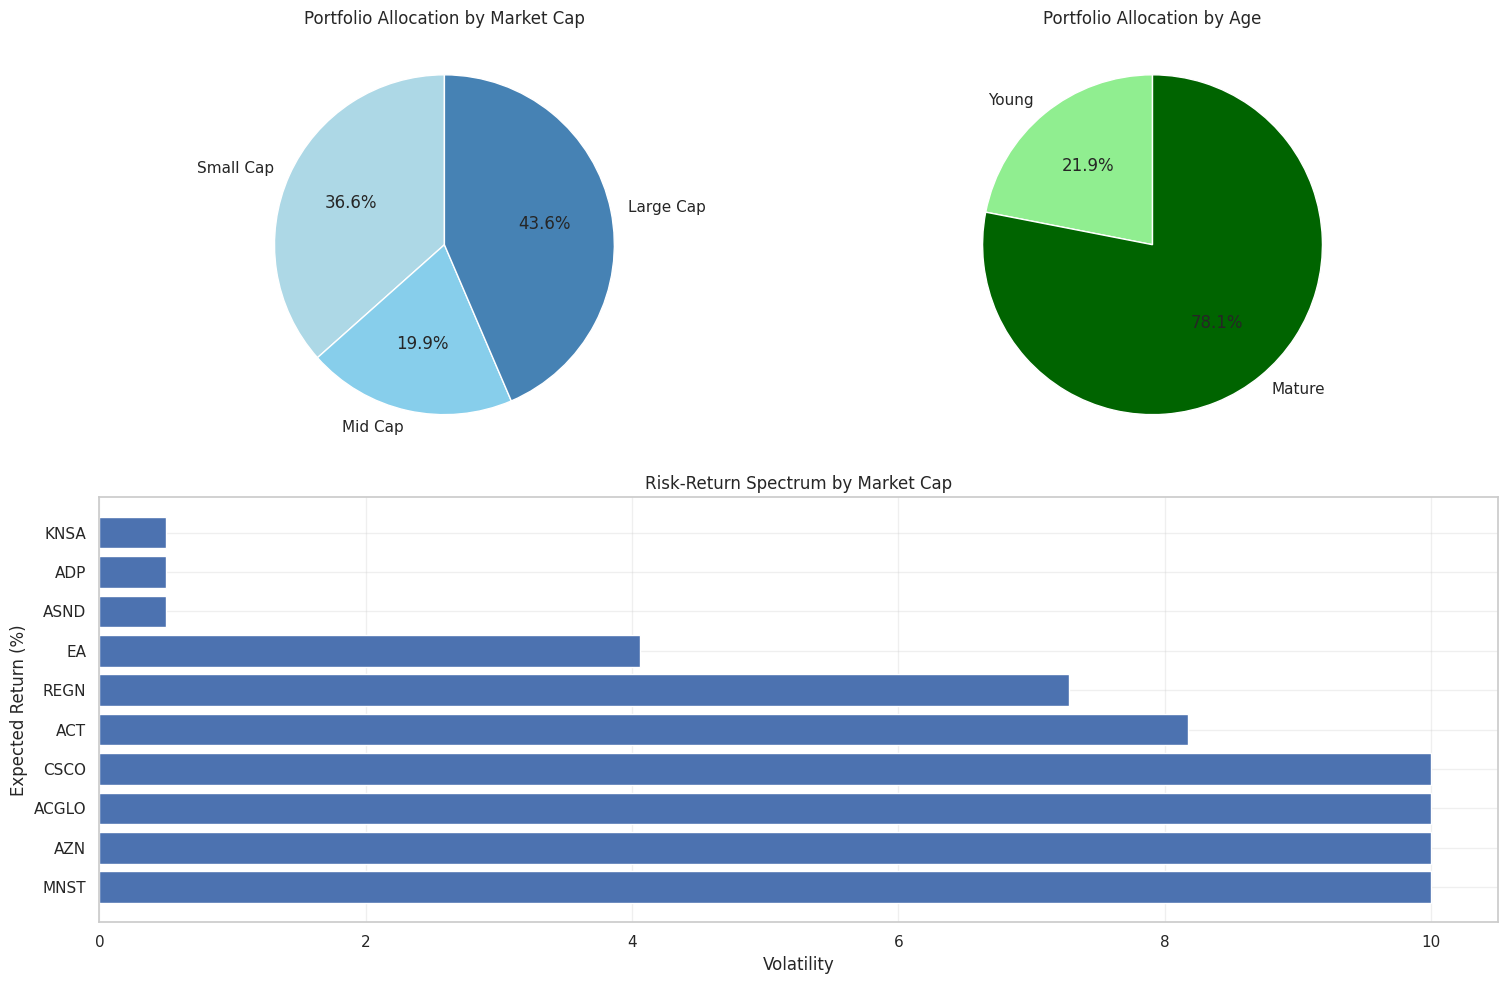

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Load datasets - modify paths as needed
print("Loading datasets...")
stock_data = pd.read_csv('eligible_stocks.csv')
risk_metrics = pd.read_csv('stock_risk_metrics.csv')

# Ensure consistent casing for stock symbols
stock_data['symbol_upper'] = stock_data['symbol'].str.upper()
risk_metrics['Stock_upper'] = risk_metrics['Stock'].str.upper()

# Combine datasets
print("\nMerging datasets...")
merged_data = pd.merge(
    stock_data,
    risk_metrics,
    left_on='symbol_upper',
    right_on='Stock_upper',
    how='inner'
)

print(f"\nCombined dataset has {len(merged_data)} stocks with both fundamental and risk metrics")

# Categorize by market cap
merged_data['market_cap_category'] = pd.cut(
    merged_data['marketCap'],
    bins=[0, 2e9, 10e9, float('inf')],
    labels=['Small Cap', 'Mid Cap', 'Large Cap']
)

# Categorize by age
merged_data['age_category'] = np.where(merged_data['Years_Since_IPO'] <= 5, 'Young', 'Mature')

# Define our universe of stocks for optimization
optimization_universe = merged_data[merged_data['eligible'] == 1].copy()
optimization_universe = optimization_universe.drop_duplicates('symbol')
print(f"\nOptimization universe: {len(optimization_universe)} eligible stocks")

# Print summary of top 10 sotcks by sharpe ratio
print("\nTop 10 stocks by Sharpe Ratio:")
category_summary = optimization_universe.groupby(['Sharpe_Ratio', 'age_category']).size().unstack()
print(category_summary)

# Prepare data for optimization
print("\nPreparing data for optimization...")
opt_df = optimization_universe.set_index('symbol')

# Create a correlation matrix from the stock data
correlation_matrix = opt_df[['Beta']].merge(
    opt_df[['Beta']],
    left_index=True,
    right_index=True,
    suffixes=('_1', '_2')
)
correlation_matrix = correlation_matrix.apply(
    lambda row: 0.5 * (1 - abs(row['Beta_1'] - row['Beta_2'])/2) + 0.5 * (row['Beta_1'] > 0 and row['Beta_2'] > 0),
    axis=1
).unstack()
np.fill_diagonal(correlation_matrix.values, 1.0)

# Create covariance matrix
vols = opt_df['Volatility']
covariance_matrix = correlation_matrix.mul(vols, axis=0).mul(vols, axis=1)

# Use Sharpe ratio for expected returns
risk_free_rate = 0.04  # 4% risk-free rate assuming treasury bonds
expected_returns = risk_free_rate + opt_df['Sharpe_Ratio'] * opt_df['Volatility']
expected_returns = expected_returns.clip(0.04, 0.20)  # Reasonable bounds

# Function to calculate portfolio statistics
def portfolio_stats(weights, returns, cov_matrix):
    """Calculate portfolio returns, volatility, and Sharpe ratio"""
    weights = np.array(weights)
    returns = np.array(returns)

    portfolio_return = np.sum(returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Assume risk-free rate of 4%
    risk_free_rate = 0.04
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return {
        'return': portfolio_return,
        'volatility': portfolio_volatility,
        'sharpe': sharpe_ratio
    }

# Basic MVO optimization function
def optimize_portfolio(returns, cov_matrix, categories):
    """
    Basic Mean-Variance Optimization with constraints:
    1. Large cap > Small and Mid combined
    2. Mature > Young
    3. 100% portfolio allocation
    """
    stocks = returns.index.tolist()
    n_stocks = len(stocks)

    # Function to minimize (negative Sharpe ratio)
    def objective_function(weights):
        stats = portfolio_stats(weights, returns.values, cov_matrix.values)
        return -stats['sharpe']  # Maximize Sharpe ratio

    # Initial weights (equal weight)
    init_weights = np.ones(n_stocks) / n_stocks

    # Bounds for each stock weight (0.5% to 10%)
    bounds = tuple((0.005, 0.10) for _ in range(n_stocks))

    # Constraint 1: Sum of weights = 1
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    # Get indices for each category
    large_cap_indices = [i for i, stock in enumerate(stocks)
                          if categories.loc[stock, 'market_cap_category'] == 'Large Cap']
    small_mid_indices = [i for i, stock in enumerate(stocks)
                          if categories.loc[stock, 'market_cap_category'] in ['Small Cap', 'Mid Cap']]
    mature_indices = [i for i, stock in enumerate(stocks)
                       if categories.loc[stock, 'age_category'] == 'Mature']
    young_indices = [i for i, stock in enumerate(stocks)
                      if categories.loc[stock, 'age_category'] == 'Young']

    # Print number of stocks in each category
    print(f"\nNumber of stocks in each category:")
    print(f"Large Cap: {len(large_cap_indices)}")
    print(f"Small/Mid Cap: {len(small_mid_indices)}")
    print(f"Mature: {len(mature_indices)}")
    print(f"Young: {len(young_indices)}")

    # Constraint 2: Large cap > Small and Mid cap combined
    if large_cap_indices and small_mid_indices:
        def large_cap_constraint(weights):
            large_cap_weight = sum(weights[i] for i in large_cap_indices)
            small_mid_weight = sum(weights[i] for i in small_mid_indices)
            return large_cap_weight - small_mid_weight  # Must be > 0

        constraints.append({'type': 'ineq', 'fun': large_cap_constraint})

    # Constraint 3: Mature > Young
    if mature_indices and young_indices:
        def mature_constraint(weights):
            mature_weight = sum(weights[i] for i in mature_indices)
            young_weight = sum(weights[i] for i in young_indices)
            return mature_weight - young_weight  # Must be > 0

        constraints.append({'type': 'ineq', 'fun': mature_constraint})

    # Run optimization
    print("\nRunning portfolio optimization...")
    result = minimize(
        objective_function,
        init_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )

    if not result.success:
        print(f"Warning: Optimization did not converge. Status: {result.message}")

    # Create optimized portfolio
    weights = pd.Series(result['x'], index=stocks)

    # Calculate portfolio statistics
    stats = portfolio_stats(result['x'], returns.values, cov_matrix.values)

    return weights, stats

# Extract categories for constraints
categories = pd.DataFrame({
    'market_cap_category': opt_df['market_cap_category'],
    'age_category': opt_df['age_category']
})

# Run the optimization
weights, stats = optimize_portfolio(expected_returns, covariance_matrix, categories)

# Print portfolio statistics
print("\nOptimized Portfolio Statistics:")
print(f"Expected Return: {stats['return']*100:.2f}%")
print(f"Expected Volatility: {stats['volatility']*100:.2f}%")
print(f"Sharpe Ratio: {stats['sharpe']:.2f}")

# Filter out zero weights and sort by weight
non_zero_weights = weights[weights > 0.001].sort_values(ascending=False)

# Get the total allocation by market cap and age category
market_cap_allocation = {}
age_allocation = {}

for stock, weight in non_zero_weights.items():
    cap = categories.loc[stock, 'market_cap_category']
    age = categories.loc[stock, 'age_category']

    if cap not in market_cap_allocation:
        market_cap_allocation[cap] = 0
    market_cap_allocation[cap] += weight

    if age not in age_allocation:
        age_allocation[age] = 0
    age_allocation[age] += weight

# Print category allocations
print("\nMarket Cap Allocation:")
for cap, allocation in sorted(market_cap_allocation.items()):
    print(f"{cap}: {allocation*100:.2f}%")

print("\nAge Allocation:")
for age, allocation in sorted(age_allocation.items()):
    print(f"{age}: {allocation*100:.2f}%")

# Print top holdings
print("\nTop 15 Holdings:")
for stock, weight in non_zero_weights.head(15).items():
    cap = categories.loc[stock, 'market_cap_category']
    age = categories.loc[stock, 'age_category']

    # Get some key metrics for this stock
    volatility = opt_df.loc[stock, 'Volatility']
    sharpe = opt_df.loc[stock, 'Sharpe_Ratio']
    exp_return = expected_returns[stock]

    print(f"{stock} ({cap}, {age}): {weight*100:.2f}% - Sharpe: {sharpe:.2f}, Vol: {volatility:.2f}, Exp Ret: {exp_return*100:.2f}%")

# Create portfolio allocation charts
plt.figure(figsize=(15, 10))

# Market cap allocation
plt.subplot(2, 2, 1)
plt.pie([market_cap_allocation.get(cap, 0) for cap in ['Small Cap', 'Mid Cap', 'Large Cap']],
        labels=['Small Cap', 'Mid Cap', 'Large Cap'],
        autopct='%1.1f%%', startangle=90, colors=['lightblue', 'skyblue', 'steelblue'])
plt.title('Portfolio Allocation by Market Cap')

# Age allocation
plt.subplot(2, 2, 2)
plt.pie([age_allocation.get(age, 0) for age in ['Young', 'Mature']],
        labels=['Young', 'Mature'],
        autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'darkgreen'])
plt.title('Portfolio Allocation by Age')

# Top holdings
plt.subplot(2, 1, 2)
top_10 = non_zero_weights.head(10)
plt.barh(top_10.index, top_10.values * 100)
plt.xlabel('Weight (%)')
plt.title('Top 10 Holdings')
plt.tight_layout()

plt.savefig('basic_mvo_portfolio_allocation.png')
print("\nPortfolio allocation chart saved as 'basic_mvo_portfolio_allocation.png'")

# Create a full portfolio report
portfolio_stocks = []

for stock, weight in non_zero_weights.items():
    stock_data = opt_df.loc[stock]
    portfolio_stocks.append({
        'Symbol': stock,
        'Weight': weight * 100,
        'Market_Cap': stock_data['market_cap_category'],
        'Age': stock_data['age_category'],
        'Expected_Return': expected_returns[stock] * 100,
        'Volatility': stock_data['Volatility'],
        'Sharpe_Ratio': stock_data['Sharpe_Ratio'],
        'Beta': stock_data['Beta'],
        'ROCE': stock_data['ROCE'],
        'Margins': stock_data['grossMargins'],
        'Growth': stock_data['revenueGrowth']
    })

portfolio_df = pd.DataFrame(portfolio_stocks)
portfolio_df.to_csv('basic_mvo_portfolio.csv', index=False)
